In [94]:
import torch
import numpy as np
import os
import cma
# from eval import play
import random

from gan.config import BaseConfig,ZeldaConfig,MarioConfig
from gan.models.general_models import Generator
from play_rl.zelda_astar import play_astar
from gan.utils import tensor_to_level_str,check_playable
from gan.level_visualizer import GVGAILevelVisualizer
from gan.game.env import Game
from gan.game.zelda import Zelda
from play_rl.wrappers import GridGame
from play_rl.policy import Policy
from PIL import Image

In [131]:
game = Zelda('v1')
config = ZeldaConfig()
config.set_env(game)
def get_model(game: Game, config: BaseConfig):
    # reproducible settings
    random.seed(config.seed)
    np.random.seed(config.seed)
    torch.manual_seed(config.seed)
    torch.cuda.manual_seed(config.seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    device = torch.device('cpu')
    # device = torch.device(
    #     f'cuda:{config.gpu_id}' if torch.cuda.is_available() else 'cpu')
    generator = Generator(
        isize=game.input_shape[1], nz=config.latent_size, nc=game.input_shape[
            0], ngf=config.generator_filters, self_attention=config.use_self_attention_g, n_extra_layers=config.extra_layers_g
    ).to(device)
    return generator
level_visualizer = GVGAILevelVisualizer(game)
generator = get_model(game,config)
model_save_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/new-68"
model_dict = torch.load(os.path.join(model_save_path, "latest.tar"))
generator.load_state_dict(model_dict['generator'])

<All keys matched successfully>

Fitness:  1000


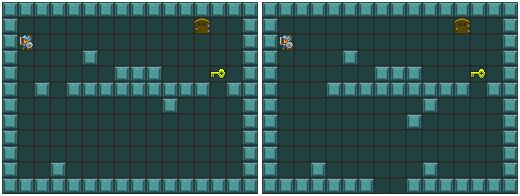

In [135]:
def f1(level_str):
    wall = 0
    enemy = 0
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if c == 'w':
                wall += 1
            if c in ['1', '2', '3']:
                enemy += 1
    return - wall - 5 * enemy


def f2(level_str):
    wall = 0
    enemy = 0
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if c == 'w':
                wall += 1
            if c in ['1', '2', '3']:
                enemy += 1
    return wall + 5 * enemy


def f3(level_str):
    wall = 0
    enemy = 0
    for i, s in enumerate(level_str):
        for j, c in enumerate(s):
            if c == 'w':
                wall += 1
            if c in ['1', '2', '3']:
                enemy += 1
    return abs(wall - 100) + 3*abs(enemy - 3)

# # env = GridGame(config.env_name, 200, env_def.state_shape)
# # actor = Policy(env.observation_space.shape, env.action_space,base_kwargs={"recurrent": True})
# # actor.load_state_dict(torch.load('/root/mnt/GVGAI-GAN/play_rl/checkpoints/ppo/zelda_20220825102126.pt'))

def fitnessf1(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1,-1)
    level,_ = generator(latent)
    level_str = game.level_tensor_to_strs(level)
    playable = game.check_playable(level_str[0])
    if not playable:
        return 1000
    # reward,step,_ = play(level_str[0],env=env,actor=actor)
    # reward, step, _ = play_astar(level_str[0], env=env)
    # return -(reward*100+step)
    ev = f1(level_str)
    return ev


def fitnessf2(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1,-1)
    level,_ = generator(latent)
    level_str = game.level_tensor_to_strs(level)
    playable = game.check_playable(level_str[0])
    if not playable:
        return 1000
    ev = f2(level_str)
    return ev


def fitnessf3(x: torch.Tensor):
    x = np.array(x)
    latent = torch.FloatTensor(x).view(1, -1)
    level, _ = generator(latent)
    level_str = game.level_tensor_to_strs(level)
    playable = game.check_playable(level_str[0])
    if not playable:
        return 1000
    ev = f3(level_str)
    return ev



def show(x):
    latent = torch.FloatTensor(x).view(1, -1)
    p_level,_ = generator(latent)
    level_strs = game.level_tensor_to_strs(p_level)
    p_level_img = np.array(level_visualizer.draw_level(level_strs[0]))
    image = Image.fromarray(p_level_img)
    image.show()


def show2(x,x2):
    latent1,latent2 = torch.FloatTensor(x).view(1, -1),torch.FloatTensor(x2).view(1,-1)
    p_level,_ = generator(latent1)
    level_strs = game.level_tensor_to_strs(p_level)
    p_level_img1 = np.array(level_visualizer.draw_level(level_strs[0]))
    p_level,_ = generator(latent2)
    level_strs = game.level_tensor_to_strs(p_level)
    p_level_img2 = np.array(level_visualizer.draw_level(level_strs[0]))
    concated = np.concatenate([p_level_img1,p_level_img2],axis=1)
    image = Image.fromarray(concated)
    image.show()

    
x = torch.randn(config.latent_size)
es = cma.CMAEvolutionStrategy(x.tolist(),0.5,{'verbose':-9})
# print(cma.CMAOptions('verb'))
# es.optimize(fitness,iterations=30,min_iterations=30)
es.optimize(fitnessf2,iterations=100,min_iterations=100)
best = np.array(es.best.get()[0])
# print("INIT: ", np.array(x.tolist()))
# print("BEST: ", best)
print("Fitness: ", fitnessf2(best))
show2(x,torch.FloatTensor(best))



In [97]:
def check(generator,fitness):
    scores = []

    wall_and_enemy_scores = []
    wall_and_enemy_changes = []

    playables = []
    playable_levels = []
    def check_level_hamming(level1: str, level2: str):
        hit = 0
        for c1, c2 in zip(level1, level2):
            if c1 == "\n":
                continue
            if c1 != c2:
                hit += 1
        return hit

    def count_wall_and_enemy(level_str: str):
        hit = 0
        for j, c in enumerate(level_str):
            if c == 'w':
                hit += 1
            if c in ['1', '2', '3']:
                hit += 5
        return hit

    for i in range(50):
        x = torch.randn(config.latent_size).view(1,-1)
        es = cma.CMAEvolutionStrategy(x.tolist(), 0.5, {'verbose': -9})
        es.optimize(fitness,iterations=100,min_iterations=100)
        best = np.array(es.best.get()[0])
        print("Fitness: ", fitness(best))
        level_first,_ = generator(x)
        level_str_first = game.level_tensor_to_strs(level_first)
        wall_and_enemy_first = count_wall_and_enemy(level_str_first[0])
        level_target,_ = generator(torch.FloatTensor(best).view(1,-1))
        level_str_target = game.level_tensor_to_strs(level_target)
        wall_and_enemy_target = count_wall_and_enemy(level_str_target[0])
        playable = game.check_playable(level_str_target[0])
        playables.append(1 if playable else 0)
        if playable:
            scores.append(fitness(best))
            wall_and_enemy_scores.append(wall_and_enemy_target)
            wall_and_enemy_changes.append(wall_and_enemy_target-wall_and_enemy_first)
            playable_levels.append(level_str_target[0])
        # show(torch.FloatTensor(best))

    hamming_dist_sum = 0
    n = 0
    for i in range(len(playable_levels)):
        for j in range(len(playable_levels)):
            if i==j: 
                continue
            hamming_dist_sum += check_level_hamming(playable_levels[i], playable_levels[j])
            n+=1

    print(f"mean score:{np.array(scores).mean()}")
    print(f"mean counts:{np.array(wall_and_enemy_scores).mean()}")
    print(f"mean changes:{np.array(wall_and_enemy_changes).mean()}")
    print(f"mean playability:{np.array(playables).mean()}")
    print(f"mean hamming dist:{hamming_dist_sum/n}")
    

In [98]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/new-71/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf1)

Fitness:  -105
Fitness:  -124
Fitness:  -117
Fitness:  -105
Fitness:  -113
Fitness:  -112
Fitness:  -116
Fitness:  -111
Fitness:  -102
Fitness:  -120
Fitness:  -123
Fitness:  -106
Fitness:  -118
Fitness:  -116
Fitness:  -113
Fitness:  -128
Fitness:  -105
Fitness:  -115
Fitness:  -119
Fitness:  -121
Fitness:  -125
Fitness:  -109
Fitness:  -105
Fitness:  -110
Fitness:  -117
Fitness:  -117
Fitness:  -115
Fitness:  -115
Fitness:  -112
Fitness:  -116
Fitness:  -114
Fitness:  -112
Fitness:  -112
Fitness:  -119
Fitness:  -101
Fitness:  -106
Fitness:  -117
Fitness:  -109
Fitness:  -114
Fitness:  -115
Fitness:  -112
Fitness:  -116
Fitness:  -120
Fitness:  -105
Fitness:  -116
Fitness:  -119
Fitness:  -109
Fitness:  -118
Fitness:  -116
Fitness:  -103
mean score:-113.66
mean counts:113.66
mean changes:27.6
mean playability:1.0
mean hamming dist:38.46775510204082


In [99]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/new-68/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf1)


Fitness:  -90
Fitness:  -95
Fitness:  -96
Fitness:  -96
Fitness:  -94
Fitness:  -93
Fitness:  -105
Fitness:  -94
Fitness:  -104
Fitness:  -95
Fitness:  -96
Fitness:  -104
Fitness:  -82
Fitness:  -92
Fitness:  -88
Fitness:  -88
Fitness:  -90
Fitness:  -83
Fitness:  -94
Fitness:  -86
Fitness:  -94
Fitness:  -104
Fitness:  -95
Fitness:  -93
Fitness:  -94
Fitness:  -84
Fitness:  -104
Fitness:  -106
Fitness:  -94
Fitness:  -99
Fitness:  -103
Fitness:  -97
Fitness:  -97
Fitness:  -94
Fitness:  -90
Fitness:  -92
Fitness:  -100
Fitness:  -95
Fitness:  -105
Fitness:  -82
Fitness:  -92
Fitness:  -88
Fitness:  -90
Fitness:  -95
Fitness:  -92
Fitness:  -87
Fitness:  -100
Fitness:  -90
Fitness:  -90
Fitness:  -104
mean score:-94.3
mean counts:94.3
mean changes:19.4
mean playability:1.0
mean hamming dist:39.4269387755102


In [100]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/new-71/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf2)


Fitness:  64
Fitness:  61
Fitness:  66
Fitness:  63
Fitness:  65
Fitness:  71
Fitness:  65
Fitness:  70
Fitness:  62
Fitness:  62
Fitness:  58
Fitness:  62
Fitness:  66
Fitness:  65
Fitness:  63
Fitness:  68
Fitness:  63
Fitness:  68
Fitness:  62
Fitness:  65
Fitness:  65
Fitness:  59
Fitness:  64
Fitness:  61
Fitness:  70
Fitness:  63
Fitness:  63
Fitness:  61
Fitness:  65
Fitness:  67
Fitness:  63
Fitness:  65
Fitness:  58
Fitness:  65
Fitness:  62
Fitness:  59
Fitness:  74
Fitness:  64
Fitness:  69
Fitness:  69
Fitness:  66
Fitness:  64
Fitness:  61
Fitness:  62
Fitness:  59
Fitness:  71
Fitness:  59
Fitness:  60
Fitness:  63
Fitness:  66
mean score:64.12
mean counts:64.12
mean changes:-20.74
mean playability:1.0
mean hamming dist:21.81142857142857


In [101]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/new-68/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf2)


Fitness:  63
Fitness:  62
Fitness:  62
Fitness:  58
Fitness:  62
Fitness:  64
Fitness:  61
Fitness:  62
Fitness:  58
Fitness:  65
Fitness:  64
Fitness:  60
Fitness:  56
Fitness:  58
Fitness:  55
Fitness:  59
Fitness:  62
Fitness:  58
Fitness:  62
Fitness:  65
Fitness:  61
Fitness:  56
Fitness:  62
Fitness:  59
Fitness:  62
Fitness:  58
Fitness:  60
Fitness:  55
Fitness:  66
Fitness:  58
Fitness:  57
Fitness:  58
Fitness:  61
Fitness:  58
Fitness:  62
Fitness:  60
Fitness:  61
Fitness:  65
Fitness:  59
Fitness:  57
Fitness:  55
Fitness:  60
Fitness:  55
Fitness:  55
Fitness:  55
Fitness:  65
Fitness:  56
Fitness:  57
Fitness:  63
Fitness:  59
mean score:59.82
mean counts:59.82
mean changes:-16.08
mean playability:1.0
mean hamming dist:13.311836734693877


In [ ]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/new-71/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf3)


In [ ]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/new-68/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf3)


In [136]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/new-74/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf2)


Fitness:  49
Fitness:  64
Fitness:  81
Fitness:  4
Fitness:  25
Fitness:  1
Fitness:  16
Fitness:  64
Fitness:  49
Fitness:  49
Fitness:  100
Fitness:  16
Fitness:  81
Fitness:  25
Fitness:  36
Fitness:  81
Fitness:  49
Fitness:  25
Fitness:  16
Fitness:  100
Fitness:  49
Fitness:  144
Fitness:  81
Fitness:  36
Fitness:  9
Fitness:  144
Fitness:  9


KeyboardInterrupt: 

In [107]:
# baseline
model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/new-74/latest.tar"
load_model = torch.load(model_path)
generator.load_state_dict(load_model["generator"])
check(generator, fitnessf1)


Fitness:  -127
Fitness:  -126
Fitness:  -128
Fitness:  -137
Fitness:  -127
Fitness:  -118
Fitness:  -126
Fitness:  -127
Fitness:  -114
Fitness:  -115
Fitness:  -112
Fitness:  -133
Fitness:  -126
Fitness:  -145
Fitness:  -140
Fitness:  -124
Fitness:  -132
Fitness:  -119
Fitness:  -116
Fitness:  -119
Fitness:  -130
Fitness:  -131
Fitness:  -132
Fitness:  -123
Fitness:  -122
Fitness:  -123
Fitness:  -118
Fitness:  -137
Fitness:  -147
Fitness:  -134
Fitness:  -129
Fitness:  -125
Fitness:  -126
Fitness:  -131
Fitness:  -121
Fitness:  -126
Fitness:  -127
Fitness:  -125
Fitness:  -129
Fitness:  -131
Fitness:  -136
Fitness:  -134
Fitness:  -124
Fitness:  -143
Fitness:  -117
Fitness:  -127
Fitness:  -136
Fitness:  -127
Fitness:  -125
Fitness:  -133
mean score:-127.6
mean counts:127.6
mean changes:34.26
mean playability:1.0
mean hamming dist:46.93061224489796


In [102]:
# # baseline
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-700/latest.tar"
# load_model = torch.load(model_path)
# generator.load_state_dict(load_model["generator"])
# check(generator, fitnessf1)


In [103]:
# # baseline
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-700/latest.tar"
# load_model = torch.load(model_path)
# generator.load_state_dict(load_model["generator"])
# check(generator, fitnessf2)

In [104]:
# # ours2
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-714/latest.tar"
# load_model = torch.load(model_path)
# generator.load_state_dict(load_model["generator"])

# check(generator,fitnessf1)


In [105]:
# # ours2
# model_path = "/root/mnt/pcg/GVGAI-GAN/gan/checkpoints/zelda_v1/none-714/latest.tar"
# load_model = torch.load(model_path)
# generator.load_state_dict(load_model["generator"])
# check(generator, fitnessf2)
